In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from fastai import *        # Quick accesss to most common functionality
from fastai.text import *   # Quick accesss to NLP functionality
import html

## Data

## Loading data

In [3]:
PATH=Path('data/wikitext-2')

In [4]:
bs = 64
bptt = 70

In [5]:
data = TextLMDataBunch.load(PATH, bs=bs, bptt=bptt)

In [6]:
from fastai.callbacks import RNNTrainer
def rnn_patch_on_loss_begin(self, last_output:Tuple[Tensor,Tensor,Tensor], **kwargs):
    "Save the extra outputs for later and only returns the true output."
    self.raw_out,self.out = last_output[1],last_output[2]
    return last_output[0], self.out


RNNTrainer.on_loss_begin = rnn_patch_on_loss_begin


# Need to find shortcut for monkey patching on individual instances - https://filippo.io/instance-monkey-patching-in-python/
# or just subclass
# learn.callbacks[0].on_loss_begin = rnn_patch_on_loss_begin

In [7]:
learn = language_model_learner(data, clip=0.2)

In [8]:
data.loss_func

In [9]:
class CosSoftmaxLoss(nn.Module):
    def __init__(self, emb_layer, base_loss):
        super().__init__()
        self.base_loss = base_loss
        self.emb_layer = emb_layer
        
    def forward(self, input, target):
        decoded, outputs = input
        with torch.no_grad():
            target_emb = self.emb_layer(target)
        base_l = self.base_loss(decoded, target)
        cos_l = (1 - torch.nn.functional.cosine_similarity(target_emb, outputs[-1].detach(), dim=2).mean())*5
        return base_l + cos_l
        

In [10]:
r_emb = learn.model[0].encoder

In [11]:
learn.loss_func = CosSoftmaxLoss(r_emb, learn.loss_func)

In [12]:
# learn.opt_fn = partial(optim.Adam, betas=(0.8,0.99))
# learn.callback_fns.extend([partial(GradientClipping, clip=0.12)])

In [13]:
epoch = 12
lr = 1e-3
momentum = (0.8,0.7)
weight_decay = 1.2e-6

In [14]:
learn.metrics = [lambda input, targs: accuracy(input[0], targs)]

In [15]:
learn.fit_one_cycle(epoch, lr, moms=momentum, wd=weight_decay)

epoch,train_loss,valid_loss,
1,10.653616,10.043700,0.113818
2,9.474977,8.903176,0.181585
3,8.835151,8.370964,0.216010
4,8.448569,8.107989,0.235085
5,8.217302,7.989928,0.246140
6,8.051781,7.944455,0.251464
7,7.922557,7.902966,0.257376
8,7.833813,7.901733,0.260447
9,7.718856,7.902232,0.262281
10,7.633715,7.904072,0.262709


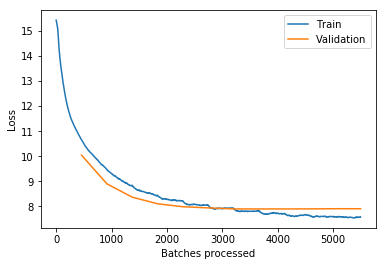

In [16]:
learn.recorder.plot_losses()

In [17]:
learn.save('lstm_wt2_newloss')

### Testing (for fun)

In [12]:
learn.load('lstm_wt103'); learn.model.eval();

In [13]:
x_str = "The online encyclopedia project Wikipedia is the most popular wiki-based website, and is"

In [14]:
pred_out = learn.predict(x_str, n_words=500)

In [15]:
pred_out

'The online encyclopedia project Wikipedia is the most popular wiki-based website, and is an influence on the xxmaj winter xxmaj olympics for finishing necessities under the active organization of the goodwill season . xxmaj architecture is both a part of the xxmaj central xxmaj central xxmaj series , an action organising system which is televised in 2011 . xxmaj once xxmaj mill xxmaj county xxmaj jail has a working 2013 xxmaj london xxmaj university weekend , the xxmaj partnership has ended soloist wills given on the xxup list as far back as 2016 . xxbos xxmaj while many of her thousands extent it ended with fruits in the xxmaj cottages and xxmaj hobby structures . xxbos = xxmaj shadows ( 2012 puzzles ) = xxbos xxmaj discovery : xxmaj domestic form is law student ( xxup a- ) . xxmaj the gu is the registry of the xxmaj highest for marriage , which allows tony to enjoy money , and have fourteen months of tolerate joining with children . a search can be read and characterized by a member